# Machine Analysis Primer For b278 VVV Tile

- **author:** JB Cabral (<jbc.develop@gmail.com>)

This binary clasification are made over a 20424 samples of the b278 tile, where:

- 424 are RRLyrae.
- 20000 are not RRLyrae.

In [34]:
% matplotlib inline

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

from sklearn import feature_selection as fs
from sklearn import preprocessing as prp
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.options.mode.chained_assignment = None 

TWO_LABELS = {-1: -1, 1: 1, 2: 1, 3: 1}

## 1. Load Data

In [44]:
df = pd.read_csv("data/amp.csv")
print "features:", len(df.columns) - 3, "- Samples:", len(df)

features: 72 - Samples: 20424


##  2. Preprocess

### 2.1. Removes all low-variance and "bad" features

In [5]:
# columns with nan and null
df = df.loc[:, ~df.isnull().any()]

X_columns = df.columns[~df.columns.isin(["vvv_id", "cls", "scls"])]
y = df["scls"].values

# low variance
vt = fs.VarianceThreshold()
vt.fit(df[X_columns].values, y)

print "total features:", len(X_columns)

total features: 62


### 2.2 Normalize Features

Standardize features by removing the mean and scaling to unit variance

In [ ]:
X_columns = X_columns[vt.get_support()]
X_scaled = prp.StandardScaler().fit_transform(df[X_columns].values)

### 2.3 Selected features

In [51]:
from IPython import display as d
d.display(d.HTML(
    "<ol>" +
    "".join("<li>{}</li>".format(c) for c in X_columns) +
    "</ol>"))

## 3. Machine Learning

The next function fit the classifier with kfolds (`default=10`) print a and retrieve:

- **fpr:** False positive rates
- **tpr:** True positive rates
- **thresh:** Decreasing thresholds on the decision function used to compute fpr and tpr
- **roc_auc:** Area under curve of ROC Curve.
- **y_test:** Array of all classes of testing samples.
- **predictions:** The prediction clases for the testing samples.
- **probabilities:** Predicted classes probabilities for tests.
- **confussion_matrix:** Confusion matrix to evaluate the accuracy of a classification

In [6]:
# helper function
def experiment(clf, x, y, nfolds=10):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:, 0]

        probabilities = np.hstack([probabilities, probs])
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1. - probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions)}

### 3.1. SVM - Linear

Execute a **SVM** with a **linear kernel**. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [12]:
%time svc_linear = experiment(svm.SVC(kernel='linear', probability=True), X_scaled, y)

             precision    recall  f1-score   support

       -1.0       0.99      1.00      0.99     20000
        1.0       0.92      0.49      0.64       424

avg / total       0.99      0.99      0.99     20424

CPU times: user 4min 26s, sys: 2.45 s, total: 4min 28s
Wall time: 4min 30s


### 3.2 SVM - Polynomic

Execute a **SVM** with a **polynomic kernel**. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [13]:
%time svc_poly = experiment(svm.SVC(kernel='poly', probability=True), X_scaled, y)

             precision    recall  f1-score   support

       -1.0       0.99      1.00      0.99     20000
        1.0       0.89      0.42      0.57       424

avg / total       0.99      0.99      0.98     20424

CPU times: user 2min 39s, sys: 1.61 s, total: 2min 41s
Wall time: 2min 41s


### 3.3. Random Forest

Execute a **Random Forest** with **500 c45** trees. All the default parameters are documented here: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [23]:
%time rf = experiment(RandomForestClassifier(n_estimators=500, criterion="entropy"), X_scaled, y)

             precision    recall  f1-score   support

       -1.0       0.99      1.00      1.00     20000
        1.0       0.97      0.54      0.70       424

avg / total       0.99      0.99      0.99     20424

CPU times: user 8min 45s, sys: 229 ms, total: 8min 45s
Wall time: 8min 45s


### 3.4. KNN

KNN with **3** neightbors ad weights determined by the **distance**. Docs: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [20]:
%time knn = experiment(KNeighborsClassifier(n_neighbors=3, weights='distance'), X_scaled, y)

             precision    recall  f1-score   support

       -1.0       0.99      1.00      0.99     20000
        1.0       0.83      0.45      0.58       424

avg / total       0.99      0.99      0.98     20424

CPU times: user 2min 31s, sys: 48 ms, total: 2min 31s
Wall time: 2min 32s


## 4. ROC

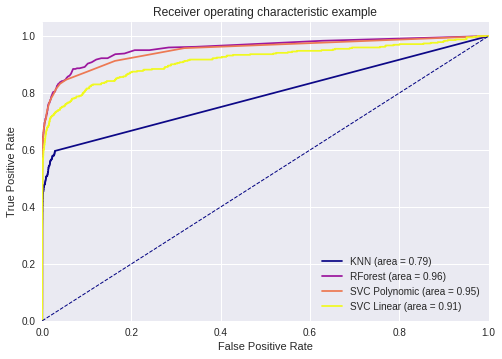

In [40]:
results = {
    "KNN": knn, 
    "RForest": rf,
    "SVC Linear": svc_linear,
    "SVC Polynomic": svc_poly}

cmap = cm.get_cmap("plasma")
colors = iter(cmap(np.linspace(0, 1, len(results))))

for cname, res  in results.items():
    color = next(colors)
    label = '%s (area = %0.2f)' % (cname, res["roc_auc"])
    plt.plot(res["fpr"], res["tpr"], color=color, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()